In [1]:
import numpy as np
import pynbody
import pynbody.units as units
import matplotlib
import matplotlib.pyplot as plt
import sys, os, glob, pickle, pylab as plt, struct

In [2]:
def load_halos_pickle(pickle_path):
    
    '''
    Returns pickle as dictionary
    '''
        
    data = pickle.load( open( pickle_path , "rb" ))
    
    
    output = dict([(str(k),np.zeros(len(data))) for k in data[1]])
    
    for i in range(len(data)):
        gal_dict = data[i]
        
        if gal_dict is not None:
            for key, value in output.items():
                try:
                    value[i] = gal_dict[str(key)] + 1e-12
                except:
                    pass
    return output

In [3]:
def density_estimate(x, y):
    
    '''
    Calculates the plot density given function m2(m1).
    Returns X, Y, Z
    '''

    from scipy import stats
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(),Y.ravel()])
    values = np.vstack([x, y])

    kernel = stats.gaussian_kde(values)

    Z = np.reshape(kernel(positions).T, X.shape)
    
    return X, Y, Z

In [4]:
#path = 'data/60/vol_halo_center_z0.205.p'
path = '/scratch/hc2347/pickles/60/main_preload_z0.205.p'

#path = 'data/60/1e5_vol_halo_metals_z0.205.p'
data = load_halos_pickle(path)
print(data.keys())

dict_keys(['mstar', 'mvir', 'z_gas', 'oxh', 'sfr_100', 'z_star', 'mgascool', 'mgas', 'sfr'])


In [5]:
massf = np.where(data['mvir'] > 10**8)

In [6]:
def do_filter(a, b):
    
    def is_valid(elm):
        return elm > 1e-12 and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]) or not is_valid(a[idx]):
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b


In [7]:
matplotlib.rcParams['font.family'] = 'serif'

In [8]:
cold_gas = data['mgascool']
mstar = data['mstar']

print(len(data['mgascool']))
cg, mst = do_filter(cold_gas,mstar)

print(len(cg))

63735
18253


18253 number of points.


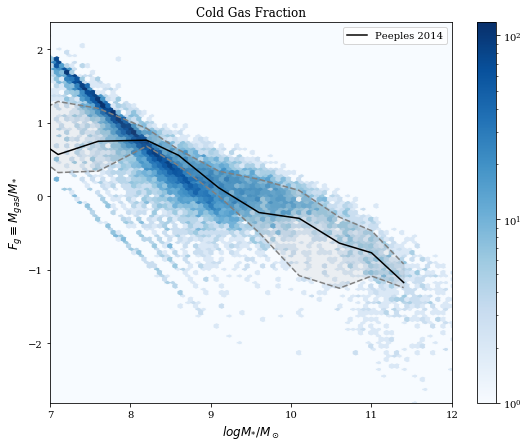

In [9]:
def plot_coldgas(mgas,mstar):
    
    mstar, mgas = do_filter(mstar, mgas)
    
    fg = mgas/mstar
    
    x = np.log10(mstar)
    y = np.log10(fg)

    
    fig, ax = plt.subplots(figsize = (9,7))
    
    print(str(len(mstar)) + ' number of points.')
    
    hb = ax.hexbin(x,y,gridsize= 100, bins='log',cmap='Blues')
    cb = fig.colorbar(hb, ax=ax)
    
    peebles = np.genfromtxt('/scratch/hc2347/references/obs/Peebles_2014_coldgas.csv',unpack=True,skip_header=2,delimiter=',')
    
    logmstar_pb = peebles[0]
    median_pb = peebles[1]
    sixteen_pb = peebles[2]
    eightyfour_pb = peebles[3]
    ax.plot(logmstar_pb, np.log10(median_pb), c='black', label = "Peeples 2014")
    ax.plot(logmstar_pb, np.log10(sixteen_pb), linestyle='dashed',color='grey')
    ax.plot(logmstar_pb, np.log10(eightyfour_pb), linestyle='dashed',color='grey')
    ax.fill_between(logmstar_pb, np.log10(sixteen_pb), y2 = np.log10(eightyfour_pb), alpha = 0.1, color='grey')
    ax.set_ylabel('$F_g \equiv M_{gas}/M_{*}$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    #ax.set_yscale('log')
    ax.legend()
    
    #ax.set_ylim(7.5,10)
    ax.set_xlim(7,12)
    
    plt.title("Cold Gas Fraction")
    plt.savefig("/scratch/hc2347/reports/cold_gas.png")

plot_coldgas(data['mgascool'],data['mstar'])

Beginning density estimate for 39916 number of points.


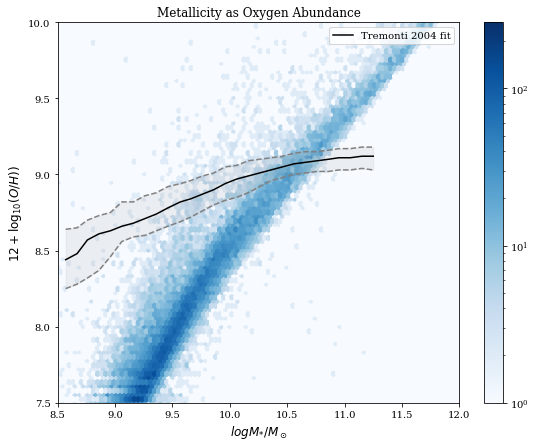

In [12]:
# Oxygen Abundance

def plot_oxh(oxh,mstar):
    
    oxh, mstar = do_filter(oxh, mstar)
    
    tremonti = np.genfromtxt('/scratch/hc2347/references/obs/Tremonti_2004_mzr.csv',unpack=True,skip_header=2,delimiter=',')
    
    median_tr = tremonti[3]
    sixteen_tr = tremonti[2]
    eightyfour_tr = tremonti[4]
    
    logmstar_tr =tremonti[0]
    
    fig, ax = plt.subplots(figsize = (9,7))
    
    print("Beginning density estimate for " + str(len(oxh)) + " number of points.")
    
    hb = plt.hexbin(oxh, np.log10(mstar), gridsize= 200, bins='log',cmap='Blues')
    plt.colorbar(hb)
    
    ax.plot(logmstar_tr, median_tr, c='black', label = "Tremonti 2004 fit")
    ax.plot(logmstar_tr, sixteen_tr, linestyle='dashed',color='grey')
    ax.plot(logmstar_tr, eightyfour_tr, linestyle='dashed',color='grey')
    ax.fill_between(logmstar_tr, sixteen_tr, y2 = eightyfour_tr, alpha = 0.1, color='grey')
    ax.set_ylabel('$12+\log_{10}(O/H))$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    ax.legend()
    
    ax.set_ylim(7.5,10)
    ax.set_xlim(8.5,12)
    
    plt.title("Metallicity as Oxygen Abundance")
    plt.savefig("/scratch/hc2347/reports/MZR_Oxh.png")

                              
plot_oxh(data['oxh'],data['mstar'])

43603
43603


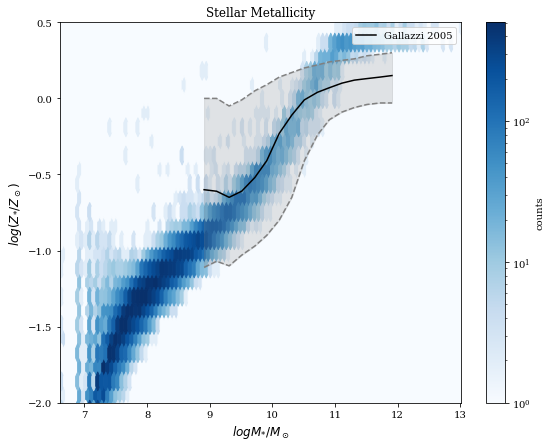

In [14]:
# Stellar Metallicity

def plot_stellar_metallicity(z_star, m_star):

    z_sol = 0.013 # primordial Solar metallicity


    x = np.log10(m_star)
    y = np.log10(z_star/z_sol)
    gallazzi = np.genfromtxt('/scratch/hc2347/references/obs/Gallazzi_2005_zstar.csv',unpack=True,skip_header=2,delimiter=',')
    logmstar_tr = gallazzi[0]

    median_tr = gallazzi[1]
    sixteen_tr = gallazzi[2]
    eightyfour_tr = gallazzi[3]

    fig, ax = plt.subplots(figsize=(9,7))
    
    plt.hexbin(x,y,gridsize=100,bins='log',cmap="Blues")
    cb = plt.colorbar()
    cb.set_label("counts")

#     X, Y, Z = density_estimate(x,y)
#     plt.contourf(X,Y,Z, 20, cmap = 'Blues')
#     plt.colorbar()

    # plot the observation.
    ax.plot(logmstar_tr, median_tr, c='black',label = "Gallazzi 2005")
    ax.plot(logmstar_tr, sixteen_tr, linestyle='dashed',color='grey')
    ax.plot(logmstar_tr, eightyfour_tr, linestyle='dashed',color='grey')
    
    ax.fill_between(logmstar_tr, sixteen_tr, y2 = eightyfour_tr, alpha = 0.2, color='grey' )
    ax.set_ylabel('$log(Z_{*}/Z_\odot)$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    ax.legend()
    
    
    plt.title("Stellar Metallicity")

    ax.set_ylim(-2,0.5)
    #ax.set_xlim(7,12)
    
    plt.savefig("/scratch/hc2347/reports/Gallazzi_SMZR.png")

z_star, m_star = do_filter(data['z_star'],data['mstar'])
print(len(z_star))
print(len(m_star))
plot_stellar_metallicity(z_star, m_star)